In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
init_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'gender'])
init_df.sample(15)

,text,gender,n_words,tokenized
233537,"Well hey everybody, so yeah i actually had fun...",male,472,"well hey everybody , so yeah i actually had fu..."
126864,"OK day, I guess. Algebra II was easy, somethin...",male,60,"ok day , i guess . algebra ii was easy , somet..."
38389,"Today (now actually yesterday, though my body-...",male,280,"today ( now actually yesterday , though my bod..."
333174,"Hey Folks, Welcome to my blog, (one of those h...",male,60,"hey folks , welcome to my blog , ( one of thos..."
214693,So I got a LiveJournal now. I guess I only rea...,male,187,so i got a livejournal now . i guess i only re...
233814,"Okee doke folks, I have completed painting him...",female,83,"okee doke folks , i have completed painting hi..."
587533,"More minor changes to the blog, mostly on the ...",male,287,"more minor changes to the blog , mostly on the..."
348130,"Day 2 came today, and I didn't feel as bad. Th...",male,128,"day 2 came today , and i did n't feel as bad ...."
25518,And I got here without even choosing a templat...,male,14,and i got here without even choosing a templat...
346722,"hi there... umm i jus wanted 2 tell u, itz wei...",female,129,"hi there ... umm i jus wanted 2 tell u , itz w..."


In [5]:
init_df.isnull().sum()

text         0
gender       0
n_words      0
tokenized    0
dtype: int64

In [6]:
# Stratify the sample by age group
df = init_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(frac=.05))
df.shape

(31780, 4)

In [7]:
df['gender'].value_counts()

male      16118
female    15662
Name: gender, dtype: int64

In [8]:
enc = LabelEncoder()
enc.fit(df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['gender'] = enc.transform(df['gender'])
encoded_labels

{'female': 0, 'male': 1}

## On initial data

In [7]:
X = df[['text']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25424, 1), (6356, 1), (25424,), (6356,))

In [8]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=4000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=4000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=4000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=4000, stop_words=None)
scl = MinMaxScaler()

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    # ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
    # ('scaler', scl, 'n_words'),
], remainder='passthrough', n_jobs=-1)

svm = SVC(kernel='linear')
logreg = LogisticRegression(
    solver='liblinear',
    penalty='l2'
)

pipe = make_pipeline(ct, logreg)

In [9]:
param_grid = {
    'logisticregression__C': [1, 10],
    'logisticregression__max_iter': [5000, 2500, 1000]
}

In [10]:
gs = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'logisticregression__C': 1, 'logisticregression__max_iter': 5000}


In [11]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      3132
           1       0.62      0.63      0.62      3224

    accuracy                           0.61      6356
   macro avg       0.61      0.61      0.61      6356
weighted avg       0.61      0.61      0.61      6356



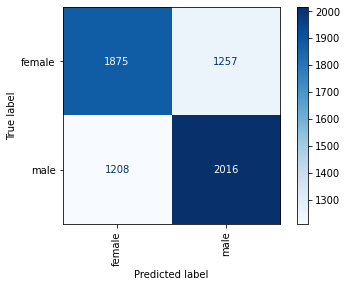

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');

## On tokenized data

In [9]:
X = df[['tokenized']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25424, 1), (6356, 1), (25424,), (6356,))

In [13]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=4000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=4000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=4000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=4000, stop_words=None)
scl = MinMaxScaler()

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'tokenized'),
    ('vect_ch_3', ch_3grams_cv, 'tokenized'),
    # ('vect_wd_2', wd_2grams_cv, 'tokenized'),
    ('vect_wd_3', wd_3grams_cv, 'tokenized'),
], remainder='passthrough', n_jobs=-1)

svm = SVC(kernel='linear')
logreg = LogisticRegression(
        solver='liblinear',
        penalty='l2'
    )

pipe = make_pipeline(ct, logreg)

In [14]:
param_grid = {
    'logisticregression__C': [1, 10],
    'logisticregression__max_iter': [5000, 2500, 1000]
}

In [15]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'logisticregression__C': 1, 'logisticregression__max_iter': 5000}


In [16]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      3132
           1       0.63      0.62      0.62      3224

    accuracy                           0.62      6356
   macro avg       0.62      0.62      0.62      6356
weighted avg       0.62      0.62      0.62      6356



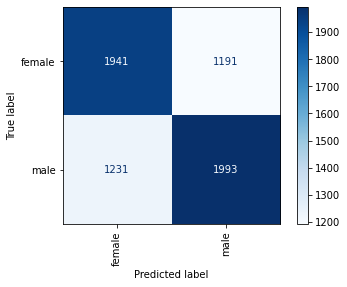

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');